# Introduction

This analysis aims to identify if cancer can be identified using circulating micro RNA (miRNA) identified from patient serum. A dataset was identified using the Gene Expression Omnibus database by Asakura et al., who studied this topic in lung cancer patients. However, as this is an exercise in machine learning, no information was taken from the paper published by Asakura et al.

Data retrieval and ETL were performed using R (see the data formatting script) to access the data via a local SQL database.

In [1]:
#Load basic libraries

import pandas as pd
import numpy as np
import sqlite3

In [2]:
#Set up out sql connection

con = sqlite3.connect("../Databases/Lung_Cancer_miRNA_DB.sqlite")

## Population Analysis

To start, we want to do some basic analysis to get an idea of what our population looks like, as this influences how we will build a model.

In [3]:
#Collect just the data pertaiing to popultion groups

DATA_INFO = pd.read_sql("SELECT sample_id, disease_state, Sex, age, tissue FROM miRNA_Table_A", con)
DATA_INFO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3924 entries, 0 to 3923
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sample_id      3924 non-null   object
 1   disease_state  3924 non-null   object
 2   Sex            3924 non-null   object
 3   age            3924 non-null   object
 4   tissue         3924 non-null   object
dtypes: object(5)
memory usage: 153.4+ KB


In [4]:
#Get some rough summaries of what is present

DATA_INFO.describe()

,sample_id,disease_state,Sex,age,tissue
count,3924,3924,3924,3924,3924
unique,3924,3,2,67,1
top,GSM4067570,Non-cancer control,Male,64,serum
freq,1,2178,2126,132,3924


From this we can tell four things:
* Each sample id is unique (as expected)
* We have more disease states than just 'case' and 'control'
* There are more males in the population than females
* All samples are serum

Because of this we can simply remove the tissue type column as it does not provide us any information.

In [5]:
#Remove tissue type

DATA_INFO = DATA_INFO.drop('tissue',axis=1)

Next we want to have a look and see what the disease states actually are.

In [6]:
#Display disease states

DATA_INFO.disease_state.unique()

array(['Non-cancer control', 'Lung cancer, pre-operation',
       'Lung cancer, post-operation'], dtype=object)

From this we can see that there are cancer and control individuals but the those with cancer can be split into pre and post operation.

To allow for groupings we can split this information into two separate columns.

In [7]:
#Split disease state infomration into two columns

DATA_INFO[['disease_state','operation_timing']] = DATA_INFO.disease_state.str.split(', ',expand = True)

Next we want to re-format data to be easier to use. First we start off by changing disease state to a boolean.

In [8]:
#Refromat disease_state

DATA_INFO['disease_state'] = DATA_INFO.disease_state.map({'Non-cancer control':False,'Lung cancer':True})

Next we need to reformat age into an integer. Normally this would happen automatically but as it is an object there is likely a non-numeric value in there.

In [9]:
#List age values

DATA_INFO['age'].unique()

array(['51', '46', '67', '56', '53', '55', '35', '31', '42', '54', '49',
       '47', '85', '64', '41', '75', '61', '59', '65', '43', '36', '38',
       '68', '60', '57', '73', '62', '48', '74', '72', '79', '77', '30',
       '58', '70', '66', '81', '80', '63', '83', '76', '71', '45', '78',
       '37', '82', '52', '69', '44', '50', '32', '39', '40', '84', '34',
       '86', '88', '26', '28', '29', '23', '25', '24', 'NA', '18', '7',
       '21'], dtype=object)

In [10]:
#Identify the lines with an age of 'NA'

DATA_INFO[DATA_INFO['age'] == 'NA']

,sample_id,disease_state,Sex,age,operation_timing
1742,GSM4069312,False,Female,NA,None


Here we can see that there is a single line with an age of NA, likely as the participant did not want their name recorded or as one was not available.

We can do one of two things with this sample: either remove it completely or set the age value as Nan. In this case the latter is applicable as we will likely not be using age as a predictor anyway.

In [11]:
#Refromat age

DATA_INFO = DATA_INFO.replace('NA', np.nan)
DATA_INFO['age'] = DATA_INFO['age'].astype('Int64')

Next we want to do some simple plots to see if our case and control groups are similar enough to compare to each other. For this we want to compare age and sex across the cases and controls.

Sex
Female    AxesSubplot(0.125,0.11;0.775x0.77)
Male      AxesSubplot(0.125,0.11;0.775x0.77)
Name: age, dtype: object

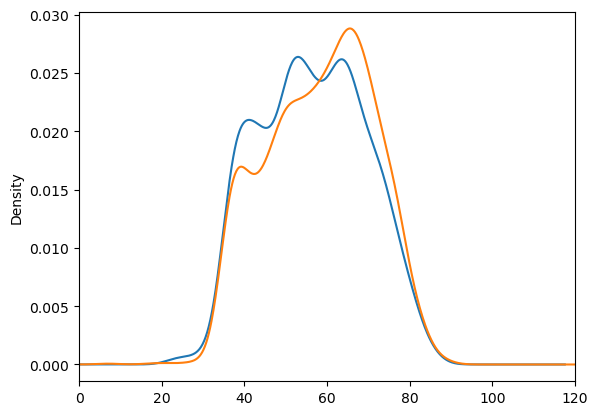

In [12]:
#Age by sex distribtion

DATA_INFO.groupby(['Sex']).age.plot.density(xlim=[0,120])

disease_state
False    AxesSubplot(0.125,0.11;0.775x0.77)
True     AxesSubplot(0.125,0.11;0.775x0.77)
Name: age, dtype: object

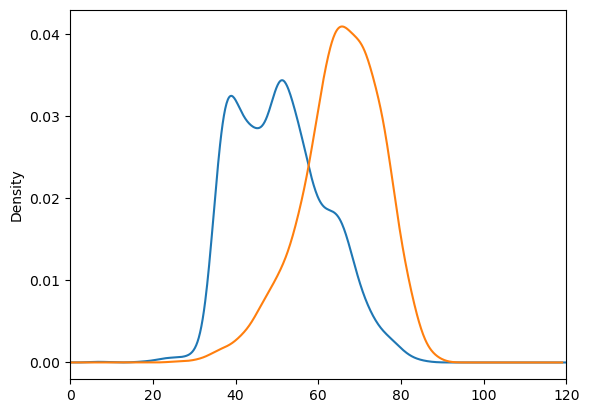

In [13]:
#Age by disease state distribtion

DATA_INFO.groupby(['disease_state']).age.plot.density(xlim=[0,120])

disease_state  Sex   
False          Female    AxesSubplot(0.125,0.11;0.775x0.77)
               Male      AxesSubplot(0.125,0.11;0.775x0.77)
True           Female    AxesSubplot(0.125,0.11;0.775x0.77)
               Male      AxesSubplot(0.125,0.11;0.775x0.77)
Name: age, dtype: object

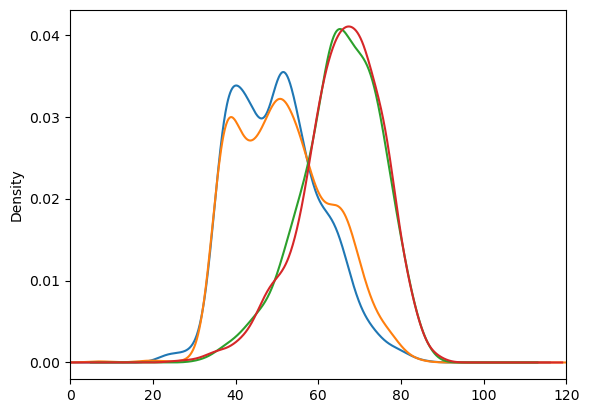

In [14]:
#Combination of the two distribtion

DATA_INFO.groupby(['disease_state','Sex']).age.plot.density(xlim=[0,120])

<AxesSubplot:ylabel='Sex'>

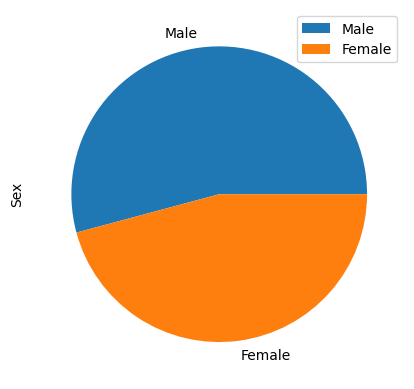

In [15]:
#Sex counts

pd.DataFrame(DATA_INFO.Sex.value_counts()).plot.pie(y='Sex')

array([<AxesSubplot:title={'center':'counts'}, xlabel='disease_state,Sex'>],
      dtype=object)

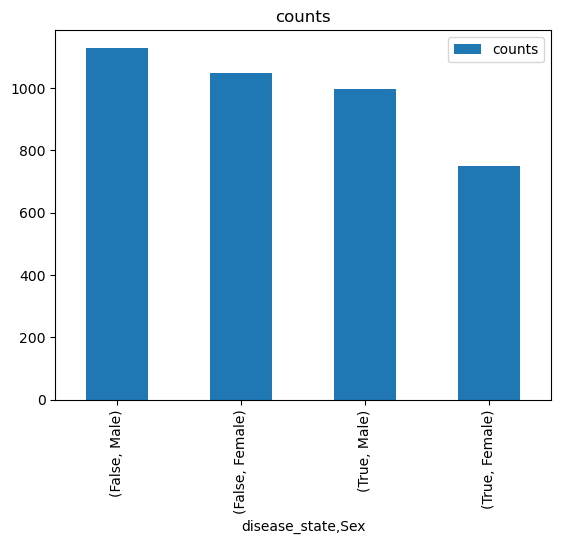

In [16]:
#Sex counts by disease state

pd.DataFrame(DATA_INFO.groupby(['disease_state']).Sex.value_counts().reset_index(name='counts')).set_index(['disease_state','Sex']).plot.bar(y='counts', subplots=True)

operation_timing
post-operation    AxesSubplot(0.125,0.11;0.775x0.77)
pre-operation     AxesSubplot(0.125,0.11;0.775x0.77)
Name: age, dtype: object

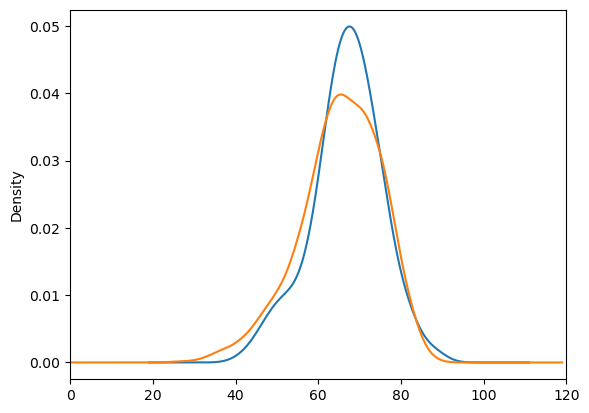

In [17]:
#Age by operation timing distribtion

DATA_INFO[DATA_INFO['disease_state'] == True].groupby(['operation_timing']).age.plot.density(xlim=[0,120])

operation_timing  Sex   
post-operation    Female    AxesSubplot(0.125,0.11;0.775x0.77)
                  Male      AxesSubplot(0.125,0.11;0.775x0.77)
pre-operation     Female    AxesSubplot(0.125,0.11;0.775x0.77)
                  Male      AxesSubplot(0.125,0.11;0.775x0.77)
Name: age, dtype: object

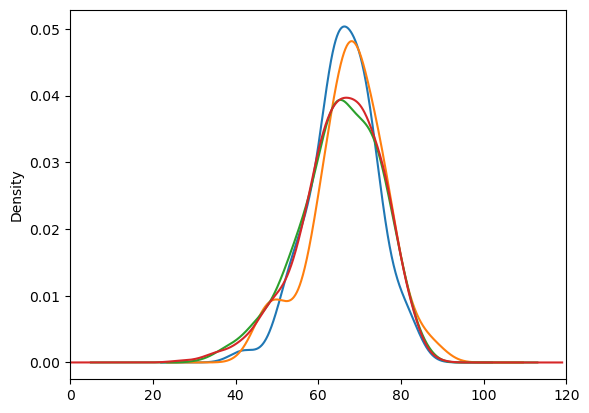

In [18]:
#Age by operation timing and sex distribtion

DATA_INFO[DATA_INFO['disease_state'] == True].groupby(['operation_timing','Sex']).age.plot.density(xlim=[0,120])

<AxesSubplot:ylabel='Sex'>

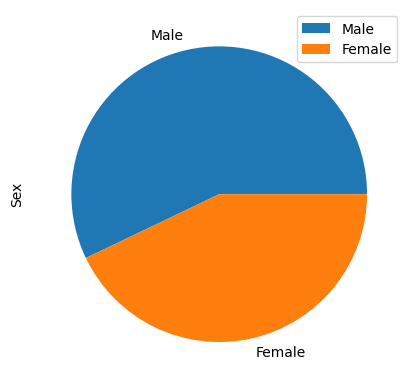

In [19]:
#Operation timing sex counts

pd.DataFrame(DATA_INFO[DATA_INFO['disease_state'] == True].Sex.value_counts()).plot.pie(y='Sex')

array([<AxesSubplot:title={'center':'counts'}, xlabel='operation_timing,Sex'>],
      dtype=object)

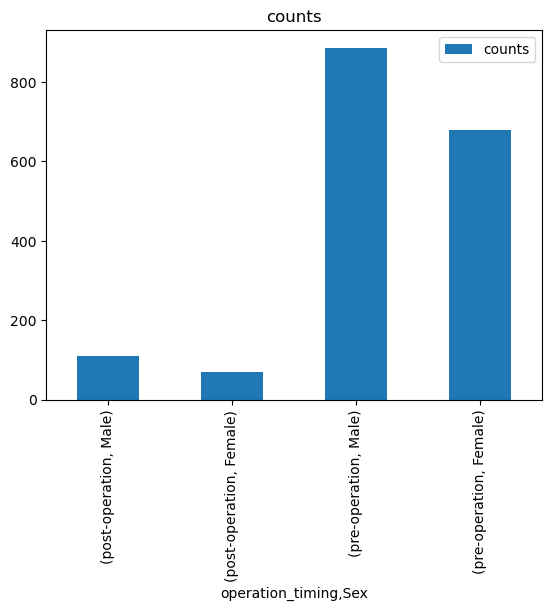

In [20]:
#Sex counts by operation timing 

pd.DataFrame(DATA_INFO[DATA_INFO['disease_state'] == True].groupby(['operation_timing']).Sex.value_counts().reset_index(name='counts')).set_index(['operation_timing','Sex']).plot.bar(y='counts', subplots=True)

Based on these basic graphs we can see that the disease state group is overall older than the control group and although there are overall slightly more males than females in the population, this is slightly higher in the case population than in the control population.

Generally we would want our cases and controls to be well matched by all metrics (in this case sex and age) but the differences should be small enough to properly train a model. We just need to be aware that the model may actually be trained on the sex/age differences between the two groups rather than on the difference in disease state.

In [21]:
#Remove dataframe

del(DATA_INFO)

## PCA Analysis

Before going through the effort to train models and test their effectiveness it's first always a good idea to see if there is actually a difference between groups. For this a PCA (principal component analysis) is a good way to get a gauge of if groups are different and how different they are.

In [22]:
#Load in the required PCA specific libraries

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [23]:
#Load in the full data set
#Note this is a little more complicated due to the column limitatons of slqlite

DATA = pd.read_sql("SELECT * FROM miRNA_Table_A", con).merge(pd.read_sql("SELECT * FROM miRNA_Table_B", con), on='sample_id')

In [24]:
#Do the data reformating as we did above

DATA = DATA.drop('tissue',axis=1)
DATA[['disease_state','operation_timing']] = DATA.disease_state.str.split(', ',expand = True)
DATA = DATA.replace('NA', np.nan)
DATA['age'] = DATA['age'].astype('Int64')
DATA['disease_state'] = DATA.disease_state.map({'Non-cancer control':False,'Lung cancer':True})

The first step we need to perform is uniform scaling of our data as PCA is sensitive to data scale. For this the standard scaler from sklearn is a nice easy and fast transform.

In [25]:
#Scale miRNA data and drop identifier columns (as we dont want to do a PCA on them)

Scaled_mirna = StandardScaler().fit_transform(DATA.drop(['sample_id','disease_state','Sex','age','operation_timing'],axis=1))

In [26]:
#Perform a PCA on the data

pca = PCA(n_components=10)
mirna_PCA = pca.fit_transform(Scaled_mirna)
PCA_table = pd.DataFrame(data = mirna_PCA,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'])

In [27]:
#Retrern the identifying infomration to the PCA results

PCA_table['disease_state'] = DATA.disease_state.astype('category')
PCA_table['Sex'] = DATA.Sex.astype('category')
PCA_table['operation_timing'] = DATA.operation_timing.astype('category')
PCA_table['age'] = DATA.age

Now that we have performed the PCA we can have a look at our data to see if our groups are different enough to train a model.

<AxesSubplot:xlabel='PC'>

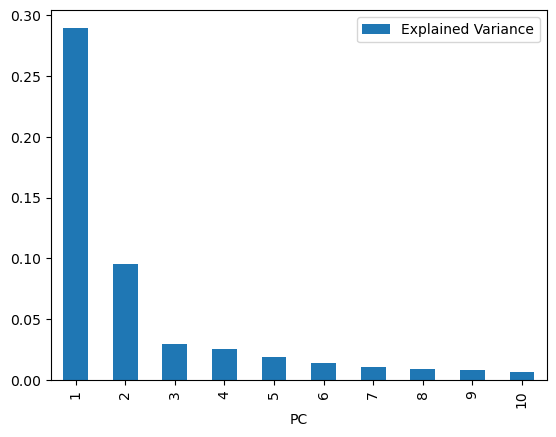

In [28]:
#Plot the variance explained by all components

pd.DataFrame({'PC':range(1,11),'Explained Variance':pca.explained_variance_ratio_}).plot.bar(x='PC',y='Explained Variance')

In [29]:
#Give the above as a table

pd.DataFrame({'PC':range(1,11),'Explained Variance':pca.explained_variance_ratio_})

,PC,Explained Variance
0,1,0.289370
1,2,0.095112
2,3,0.029816
3,4,0.025518
4,5,0.019157
5,6,0.013738
6,7,0.010457
7,8,0.009187
8,9,0.008395
9,10,0.006403


We can see from this that PC1 explains by far the most variance but does not explain much overall. So we should plot the data to see if we can discern our groupings.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

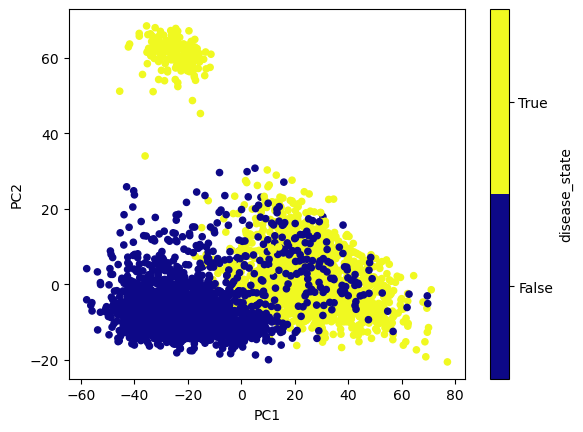

In [30]:
#Basic scatter plot of components shaded by disease state

PCA_table.plot.scatter(x='PC1',y='PC2',c='disease_state',colormap='plasma')

From this we can see that there is a decent separation between the case and control groups although there is a moderate amount of overlap between them. Oddly though the case samples fit into two distinct clusters in these two dimensions. As we know that the case samples fit into pre and post operation groupings we should check to see if this fits the two clusters.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

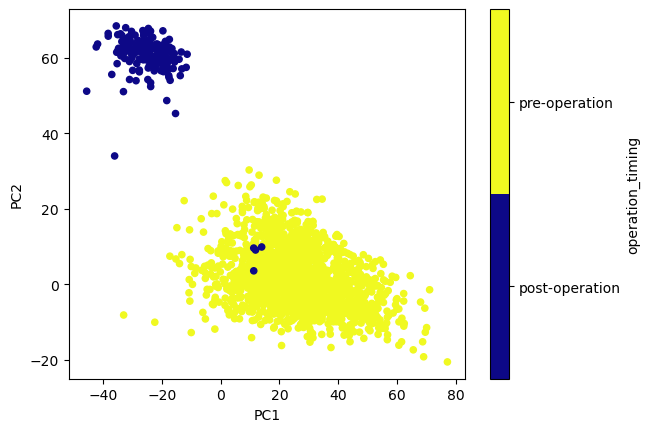

In [31]:
#Basic scatter plot of components for samples with cancer shaded by operation timing

PCA_table[PCA_table['disease_state'] == True].plot.scatter(x='PC1',y='PC2',c='operation_timing',colormap='plasma')

So it looks like using these two components there is really good separation between the pre and post operation groups, even more so than between cases and controls.

Next we want to just have a quick look to see if sex or age is driving our groupings.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

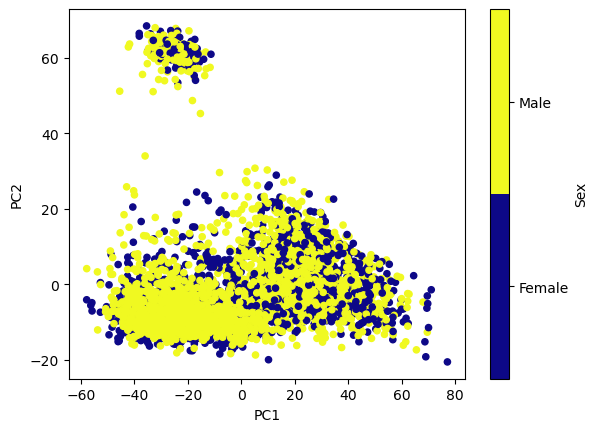

In [32]:
#Basic scatter plot of components shaded by sex

PCA_table.plot.scatter(x='PC1',y='PC2',c='Sex',colormap='plasma')

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

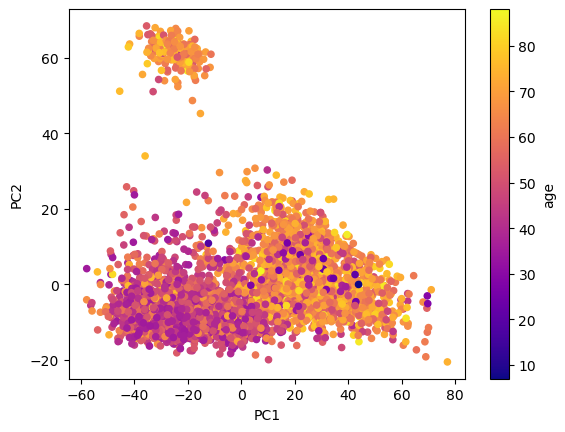

In [33]:
#Basic scatter plot of components shaded by age

PCA_table.plot.scatter(x='PC1',y='PC2',c='age',colormap='plasma')

Here we can see that sex and age are not the things driving out groupings so it looks like there is sufficient difference between cases and controls to train a model.

However, as there is still overlap between the two it's worth checking to see if our third principle component is differentiating cases and controls more.

Text(0.5, 0, 'PC3')

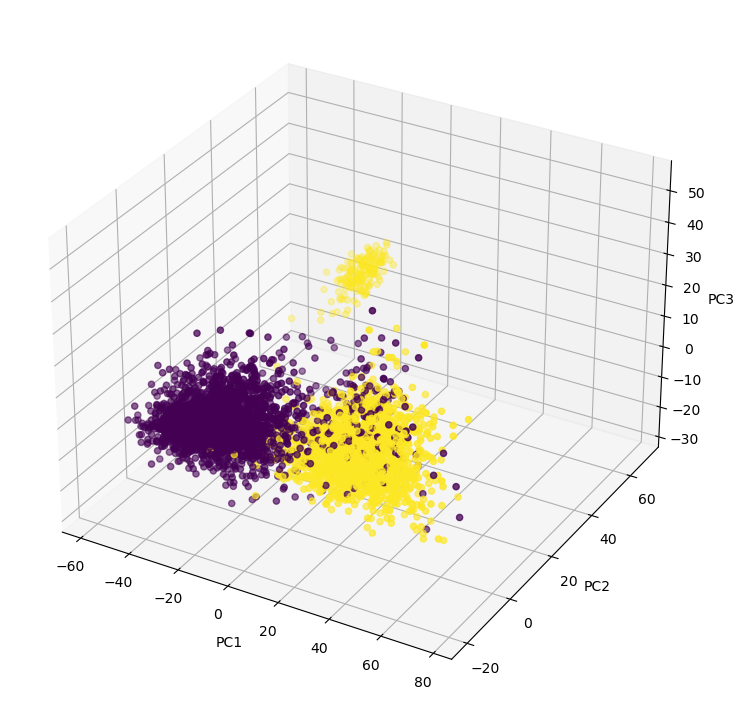

In [34]:
#Make a 3D plot

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

#Remove this hash to make it interactive
#%matplotlib notebook

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection="3d")
ax.scatter3D(PCA_table.PC1, PCA_table.PC2, PCA_table.PC3, c = PCA_table.disease_state)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

<AxesSubplot:xlabel='PC2', ylabel='PC3'>

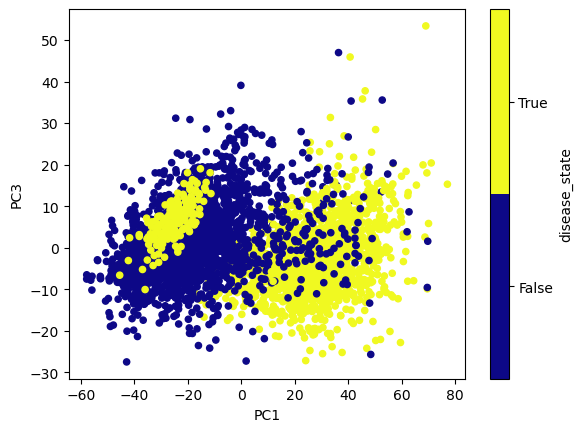

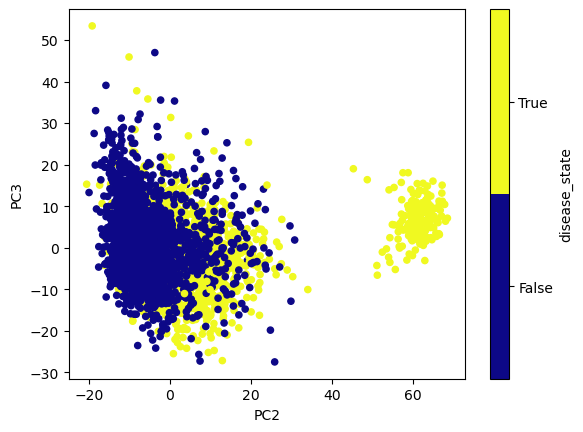

In [35]:
#Make 2D plots

%matplotlib inline
PCA_table.plot.scatter(x='PC1',y='PC3',c='disease_state',colormap='plasma')
PCA_table.plot.scatter(x='PC2',y='PC3',c='disease_state',colormap='plasma')

In [36]:
#Remove data

del(mirna_PCA)

From this we can see that unfortunately PC3 is not really doing anything to differentiate our groupings.
It's possible that the post-operation group is so different from the other two that it is masking the differences so we will do a PCA on the data excluding this group.

In [37]:
#Do PCA without post-operation

pca = PCA(n_components=10)
Scaled_mirna = StandardScaler().fit_transform(DATA.drop(DATA[DATA.operation_timing == 'post-operation'].index).drop(['sample_id','disease_state','Sex','age','operation_timing'],axis=1))
mirna_PCA = pca.fit_transform(Scaled_mirna)
PCA_table = pd.DataFrame(data = mirna_PCA,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'])
PCA_table['disease_state'] = DATA.disease_state.astype('category')
PCA_table['Sex'] = DATA.Sex.astype('category')
PCA_table['operation_timing'] = DATA.operation_timing.astype('category')
PCA_table['age'] = DATA.age

<AxesSubplot:xlabel='PC'>

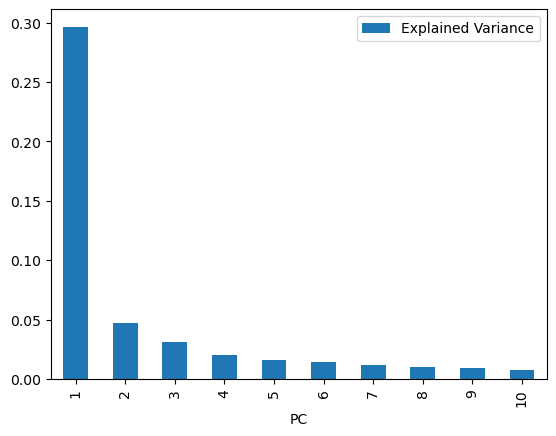

In [38]:
#Plot the variance explained by all components

pd.DataFrame({'PC':range(1,11),'Explained Variance':pca.explained_variance_ratio_}).plot.bar(x='PC',y='Explained Variance')

In [39]:
#Give the above as a table

pd.DataFrame({'PC':range(1,11),'Explained Variance':pca.explained_variance_ratio_})

,PC,Explained Variance
0,1,0.296450
1,2,0.046803
2,3,0.031372
3,4,0.020038
4,5,0.016152
5,6,0.014230
6,7,0.011455
7,8,0.010352
8,9,0.008979
9,10,0.007448


Text(0.5, 0, 'PC3')

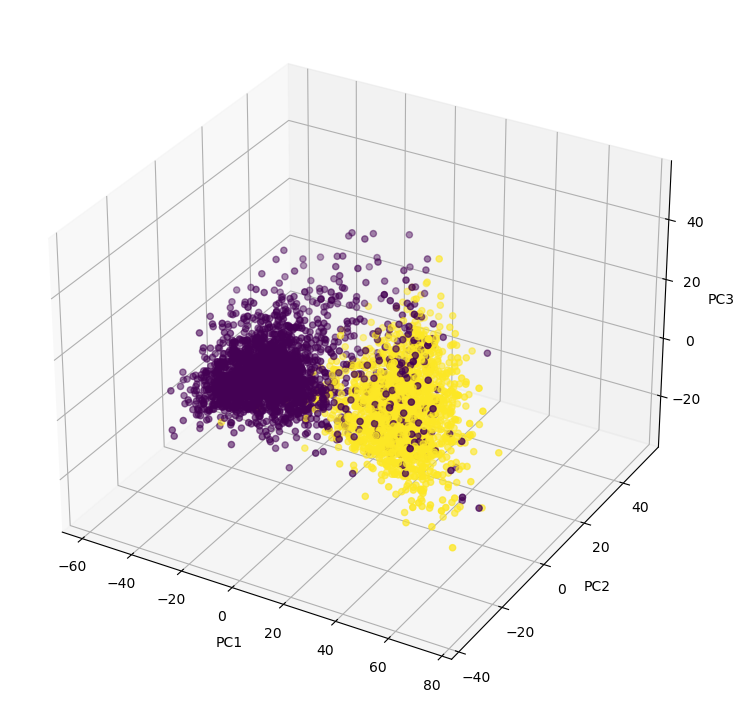

In [40]:
#Make a 3D plot

#Remove this hash to make it interactive
#%matplotlib notebook

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection="3d")
ax.scatter3D(PCA_table.PC1, PCA_table.PC2, PCA_table.PC3, c = PCA_table.disease_state)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

<AxesSubplot:xlabel='PC2', ylabel='PC3'>

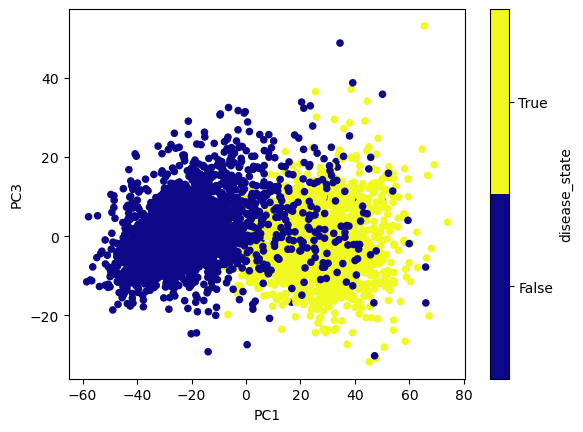

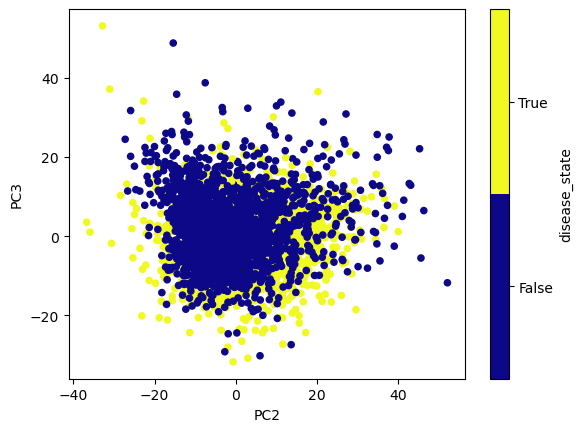

In [41]:
#Make 2D plots

%matplotlib inline
PCA_table.plot.scatter(x='PC1',y='PC3',c='disease_state',colormap='plasma')
PCA_table.plot.scatter(x='PC2',y='PC3',c='disease_state',colormap='plasma')

Here we can see that removing the post-operation group did not really have an effect on our data and there is still moderate overlap between our groups.

Let's have a look at what is contributing to PC1.

<AxesSubplot:xlabel='Component'>

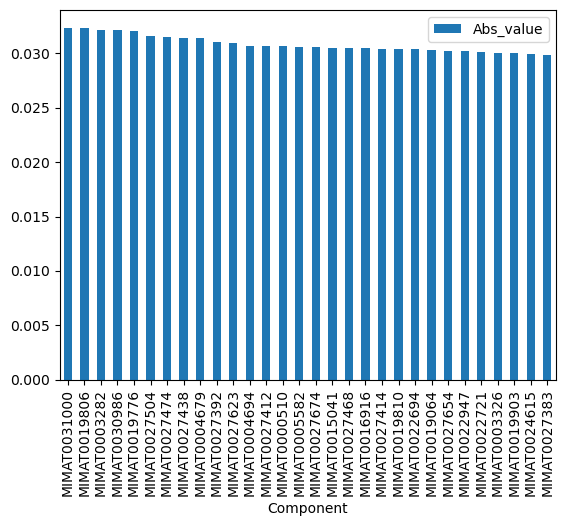

In [42]:
#Plot components of PC1

PC1_Components = pd.DataFrame({'Component':DATA.head(1).drop(['sample_id','disease_state','Sex','age','operation_timing'],axis=1).columns.tolist(),'Value':pca.components_[0]}) 
PC1_Components['Abs_value'] = PC1_Components.Value.abs()
PC1_Components.sort_values('Abs_value', ascending=False).head(30).plot.bar(x='Component',y='Abs_value')

In [43]:
PC1_Components.Abs_value.describe()

count    2565.000000
mean        0.018072
std         0.007955
min         0.000005
25%         0.012932
50%         0.020275
75%         0.024116
max         0.032378
Name: Abs_value, dtype: float64

From this we can see that PC1 is a combination of a lot of different components with none really standing out as being most important.

Now we want to generate a model to classify samples to be able to predict cancer status based on circulating miRNA.

# K-Nearest Neigbours Clustering Classification

K-nearest neighbors classification is a good robust model type which we can use for this data.

In [44]:
#Load in the required K-Means specific libraries

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


#Turn off furure changes warnings
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

First we split our data into test validation datasets. Here we have removed the 'post-operation' cases as, due to them being so different from the other cases based on our PCA, they are likely to throw off the PCA.

In [45]:
#Make test and validation set (0.8:0.2)

x, x_val, y, y_val = train_test_split(DATA.drop(DATA[DATA.operation_timing == 'post-operation'].index).drop(['operation_timing','Sex','age','sample_id','disease_state'],axis = 1), DATA.drop(DATA[DATA.operation_timing == 'post-operation'].index).disease_state, test_size=0.2)

In [46]:
#Train model

knear_model = KNeighborsClassifier(weights = 'distance')
knear_model.fit(x,y)

KNeighborsClassifier(weights='distance')

In [47]:
#Test model

val_predictions = knear_model.predict(x_val)
conn_matrix = confusion_matrix(y_val, val_predictions)
accuracy = (conn_matrix[0, 0] + conn_matrix[1, 1]) / float(np.sum(conn_matrix))
TPR = (conn_matrix[0, 0] / float(np.sum(conn_matrix[0, :])))
TNR = (conn_matrix[1, 1] / float(np.sum(conn_matrix[1, :])))
F1 = 2*(TPR*TNR) / (TPR +TNR)
print('Accuracy:',accuracy,'\nTPR:',TPR,'\nTNR:',TNR,'\nF1:',F1)

Accuracy: 0.835781041388518 
TPR: 0.9108433734939759 
TNR: 0.7425149700598802 
F1: 0.8181104148848899


Text(0, 0.5, 'TPR')

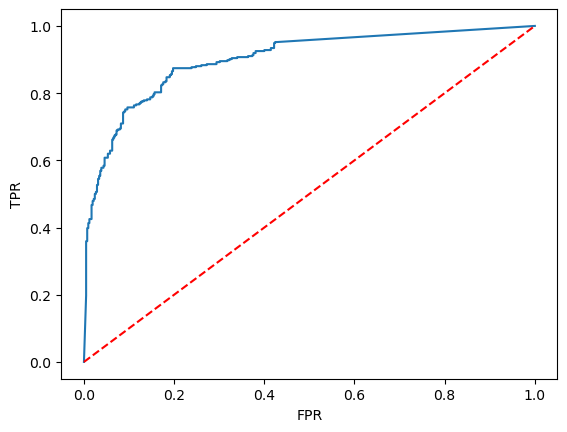

In [48]:
#Make ROC Curve

FPR, TPR, thrsh = roc_curve(y_val, knear_model.predict_proba(x_val)[:,1])
plt.figure()
plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')

We can see that just using the default parameters we get a relatively accurate model. However we can do better, first by finding the optimal number of neighbors to use for the model.

First we need to split our training data into a training and test set in order to leave the validation set for final validation.

In [49]:
#Split test and train data

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = (0.2/0.8))

In [50]:
#Find best k-value

Model_training = pd.DataFrame(columns=['n','accuracy','TPR','TNR','F1'])
for n in range(1,51):
    knear_model = KNeighborsClassifier(n_neighbors=n,weights = 'distance')
    knear_model.fit(x_train,y_train)
    conn_matrix = confusion_matrix(y_test, knear_model.predict(x_test))
    Model_training = Model_training.append({'n':n,
                                            'accuracy':(conn_matrix[0, 0] + conn_matrix[1, 1]) / float(np.sum(conn_matrix)),
                                            'TPR':(conn_matrix[0, 0] / float(np.sum(conn_matrix[0, :]))),
                                            'TNR':(conn_matrix[1, 1] / float(np.sum(conn_matrix[1, :]))),
                                            'F1':2*((conn_matrix[0, 0] / float(np.sum(conn_matrix[0, :])))*(conn_matrix[1, 1] / float(np.sum(conn_matrix[1, :]))))/((conn_matrix[0, 0] / float(np.sum(conn_matrix[0, :])))+(conn_matrix[1, 1] / float(np.sum(conn_matrix[1, :]))))
                                           },ignore_index=True)

<AxesSubplot:xlabel='n'>

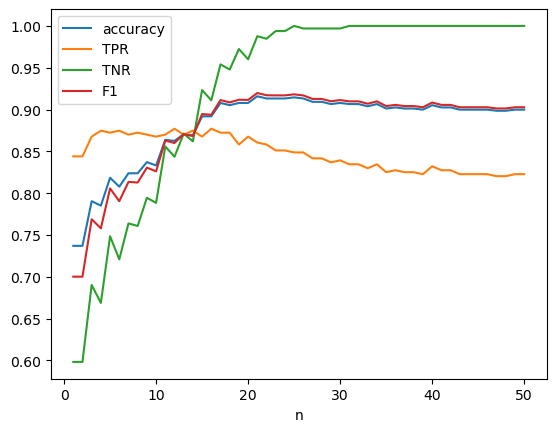

In [51]:
#Plot results

Model_training.plot.line(x='n',y=['accuracy','TPR','TNR','F1'])

Based on this data it would appear that the optimal number of neighbors is around 15-20.

Another method we can use to improve our model is by removing variables which do affect the difference between groups. As we saw that the primary difference between cases and controls was PC1 we can investigate removing the lowest contributors to PC1 to see if it improves the accuracy of the model.

<AxesSubplot:xlabel='Component'>

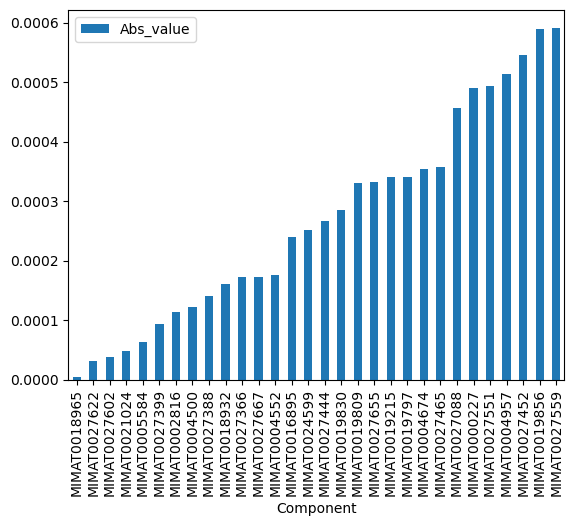

In [52]:
#Look at bottom contributors of PC1

PC1_Components.sort_values('Abs_value', ascending=True).head(30).plot.bar(x='Component',y='Abs_value')

In [53]:
PC1_Low_Components = PC1_Components.sort_values('Abs_value', ascending=True)
knear_model = KNeighborsClassifier(n_neighbors=20, weights = 'distance')

Model_dim_training = pd.DataFrame(columns=['percentile_removed','accuracy','TPR','TNR','F1'])
for n in range(0,101):
    del_list = PC1_Low_Components.head(int(np.ceil(n/1000*len(PC1_Low_Components.index)))).Component.tolist()
    knear_model.fit(x_train.drop(del_list,axis=1),y_train)
    conn_matrix = confusion_matrix(y_test, knear_model.predict(x_test.drop(del_list,axis=1)))
    Model_dim_training = Model_dim_training.append({'percentile_removed':n/10,
                                            'accuracy':(conn_matrix[0, 0] + conn_matrix[1, 1]) / float(np.sum(conn_matrix)),
                                            'TPR':(conn_matrix[0, 0] / float(np.sum(conn_matrix[0, :]))),
                                            'TNR':(conn_matrix[1, 1] / float(np.sum(conn_matrix[1, :]))),
                                            'F1':2*((conn_matrix[0, 0] / float(np.sum(conn_matrix[0, :])))*(conn_matrix[1, 1] / float(np.sum(conn_matrix[1, :]))))/((conn_matrix[0, 0] / float(np.sum(conn_matrix[0, :])))+(conn_matrix[1, 1] / float(np.sum(conn_matrix[1, :]))))
                                           },ignore_index=True)

<AxesSubplot:xlabel='percentile_removed'>

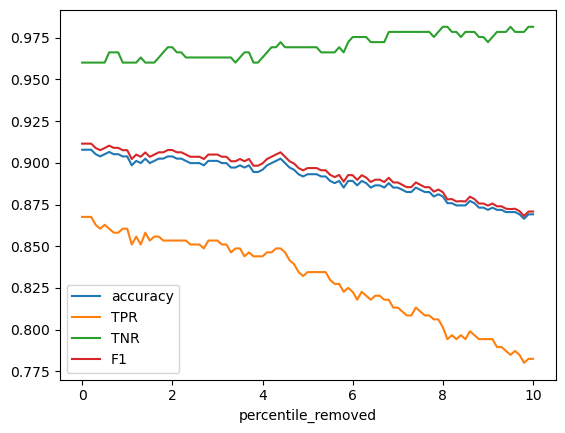

In [54]:
#Plot results

Model_dim_training.plot.line(x='percentile_removed',y=['accuracy','TPR','TNR','F1'])

As we can clearly see, removing dimensions is only detrimental. Thus it will not be done for the final model.

Now the only thing left is to build and test the final model on the validation set.

In [55]:
#Build final model

knear_model = KNeighborsClassifier(n_neighbors=20, weights = 'distance')
knear_model.fit(x_train,y_train)
val_predictions = knear_model.predict(x_val)
conn_matrix = confusion_matrix(y_val, val_predictions)
accuracy = (conn_matrix[0, 0] + conn_matrix[1, 1]) / float(np.sum(conn_matrix))
TPR = (conn_matrix[0, 0] / float(np.sum(conn_matrix[0, :])))
TNR = (conn_matrix[1, 1] / float(np.sum(conn_matrix[1, :])))
F1 = 2*(TPR*TNR) / (TPR +TNR)
print('Accuracy:',accuracy,'\nTPR:',TPR,'\nTNR:',TNR,'\nF1:',F1)

Accuracy: 0.9172229639519359 
TPR: 0.8843373493975903 
TNR: 0.9580838323353293 
F1: 0.9197346678257328


Text(0, 0.5, 'TPR')

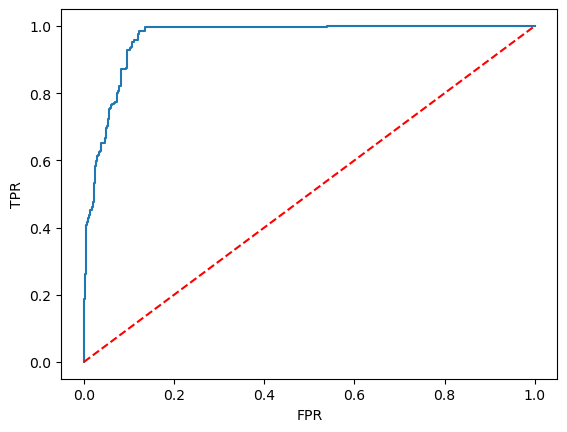

In [56]:
#Make ROC Curve

FPR, TPR, thrsh = roc_curve(y_val, knear_model.predict_proba(x_val)[:,1])
plt.figure()
plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')

As you can see training the model has improved but at the cost of the true positive rate.

As this model is predicting if someone has cancer it may be important to optimize for true positive rate in addition to overall accuracy as the intention may be to select individuals for cancer screening. However, given the observations for true positive rate in the model training this would be difficult to achieve with a k-nearest neighbors classification.

In [57]:
#Save model

import pickle 
knn = open('cancer_knear_model', 'wb') 
pickle.dump(knear_model, knn)
knn.close()

# Logistic Regression

Logistic regression is another robust model for bimodal classification which we can use.

In [58]:
#Load in the required logistic regression specific libraries

from sklearn.linear_model import LogisticRegression

In [59]:
#Train model

logicR = LogisticRegression(max_iter = 500)
logicR.fit(x_train,y_train)

LogisticRegression(max_iter=500)

In [60]:
#Test model

val_predictions = logicR.predict(x_val)
conn_matrix = confusion_matrix(y_val, val_predictions)
accuracy = (conn_matrix[0, 0] + conn_matrix[1, 1]) / float(np.sum(conn_matrix))
TPR = (conn_matrix[0, 0] / float(np.sum(conn_matrix[0, :])))
TNR = (conn_matrix[1, 1] / float(np.sum(conn_matrix[1, :])))
F1 = 2*(TPR*TNR) / (TPR +TNR)
print('Accuracy:',accuracy,'\nTPR:',TPR,'\nTNR:',TNR,'\nF1:',F1)

Accuracy: 0.9946595460614153 
TPR: 0.9951807228915662 
TNR: 0.9940119760479041 
F1: 0.9945960061221085


This is an exceedingly good model so let's check the ROC curve

Text(0, 0.5, 'TPR')

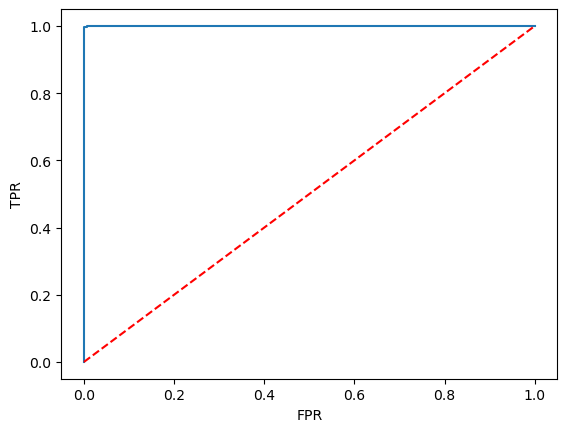

In [61]:
#Make ROC Curve

FPR, TPR, thrsh = roc_curve(y_test, logicR.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')

This is incredibly surprising (and slightly suspicious) that a logical regression would be this good so let's intentionally feed it incorrect data (values from the test data and labels from the validation data) to see how that performs.

Text(0, 0.5, 'TPR')

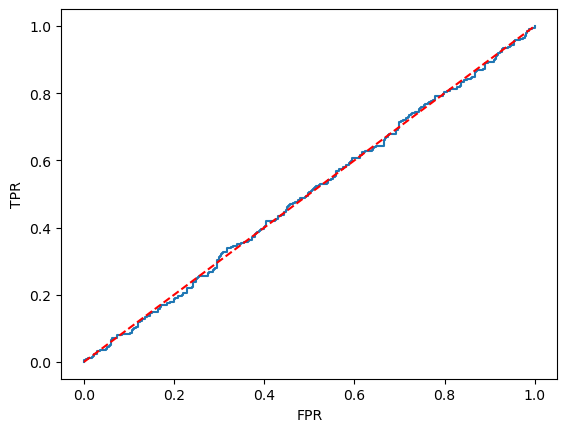

In [62]:
FPR, TPR, thrsh = roc_curve(y_val, logicR.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')

About as expected for 'random' data. Based on this it looks like logistic regression works incredibly well in this instance.

In [63]:
#Save model

logicR = LogisticRegression(max_iter = 500)
logicR.fit(x_train,y_train)
logR = open('cancer_logicr_model', 'wb') 
pickle.dump(logicR, logR)
logR.close()

Based on the two models, the best to use is by far the logical regression model as it has incredibly high accuracy with incredibly high accuracy and F1 and an excellent ROC curve.

# Conclusion

We can see from the PCA and both machine learning models that cancer status can be predicted using circulating miRNA. Based on the results seen here, logistic regression is by far the best model to use, given the F1 value of this model (0.997). While initially, this appears to be an excellent way to detect the presence of cancer in an individual, there are still several unknowns:

    * It is not yet known if this method or model is valid in all types of cancer
    * It is not known if other factors influence circulating miRNA

For the second unknown, we have data that indicated that other factors influence circulating miRNA as the post-operation cancer group is in a separate cluster from pre-operation cancer and healthy samples. Due to this, we don't know if cancer causes unique and identifiable changes in miRNA or if the changes are caused simply by a disease. So before we claim that this model can detect cancer, we will want to investigate these factors.

On the topic of the post-operation cancer group, let's see what the logistic regression model predicts in their case.

In [64]:
post_op_x = DATA[DATA.operation_timing == 'post-operation'].drop(['operation_timing','Sex','age','sample_id','disease_state'],axis = 1)
post_op_predictions = pd.DataFrame(data = pd.DataFrame(logicR.predict(post_op_x)).value_counts(), columns = ['count'])
post_op_predictions['percentage'] = post_op_predictions['count']/sum(post_op_predictions['count'])*100
post_op_predictions

,count,percentage
0,,
False,176,97.777778
True,4,2.222222


From this, we can see that 97.8% of post-operation cancer cases are predicted to be cancer-free. If we were to follow up on these patients, we could also test to see how accurate this model would be in predicting cancer treatment success via an operation to remove the tumor.